In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import json
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import powerlaw
import numpy as np
from sklearn.linear_model import LinearRegression
import statistics
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
seed = 42

# Network Summary

## Data mining and preprocessing, general charachteristics, basic visualization

This network represents a schema of figure skaters following each other on Instagram (designated as an extremist organization by the Russian government). The data was collected manually by downloading HTML pages from Instagram accounts. Since Instagram uses dynamic page updates, I utilized the `copy_outer_html` function to extract the data. Subsequently, the `BeautifulSoup` was utilized for parsing. Only publicly available accounts were collected to comply with Instagram's policies. 

The downloaded data can be found in the `insta_follows` folder, the complete preprocessing workflow can be found in `data_parsing.py`, and the graph itself in JSON-format is located in `fs_inst_following.json`. Graph attributes, including point scores and full names, were collected from the [Official ISU website](https://www.isuresults.com/bios/). Links to the pages were manually gathered and can be found in `FS_nicks_links.csv`. In cases where automatic parsing was not possible, scores were calculated manually and stored in this CSV table. The parsing code is available in `isu_site_parsing.py`.

The data was collected using a balanced sampling approach. Figure skating comprises four disciplines: **women's singles**, **men's singles**, **pairs**, and **ice dance**. To minimize bias, an equal number of skaters was selected from each category: 26 women's singles skaters, 26 men's singles skaters, 26 pairs skaters (comprising 13 men and 13 women), 26 ice dance skaters (similarly, 13 men and 13 women). In total, 104 accounts were analyzed.

The network thus has the following charachteristics:
- each node represents an athlete's Instagram account; there are **104 nodes** in total;
- overall, **2324 edges** are represented;
- each directed edge represents a "following" relationship between two accounts, meaning the network is **directed**;
- all edges have equal weight, meaning the network is **unweighted**;
- the set of nodes is **homogeneous**, as all individuals belong to the same professional community (elite figure skating).

The nodes have following attributes:
- figure skating discipline;
- a merit-based point score for each skater, calculated according to [ISU World Standings and Season's World Ranking](https://en.wikipedia.org/wiki/ISU_World_Standings_and_Season%27s_World_Ranking);
- athlete's full name

All mentioned scripts, full dataset, this notebook, and the project presentation are available on the [project's GitHub page](https://github.com/vixbi/social_network_project).

In [3]:
with open('fs_inst_following.json', 'r', encoding='utf-8') as f:
    graph_dict = json.load(f)

In [4]:
G = nx.DiGraph()

G.add_nodes_from(graph_dict.keys())
for follower, following_list in graph_dict.items():
    for following in following_list:
        if following in graph_dict.keys():
            G.add_edge(follower, following)

# short descriptives
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 104, Edges: 2324


In [5]:
with open("graph_attributes.json") as f:
    graph_attributes = json.load(f)

for node in G.nodes:
    for attr_name, attr_value in graph_attributes[node].items():
        G.nodes[node][attr_name] = attr_value

In [6]:
nx.write_gexf(G, 'graph.gexf')

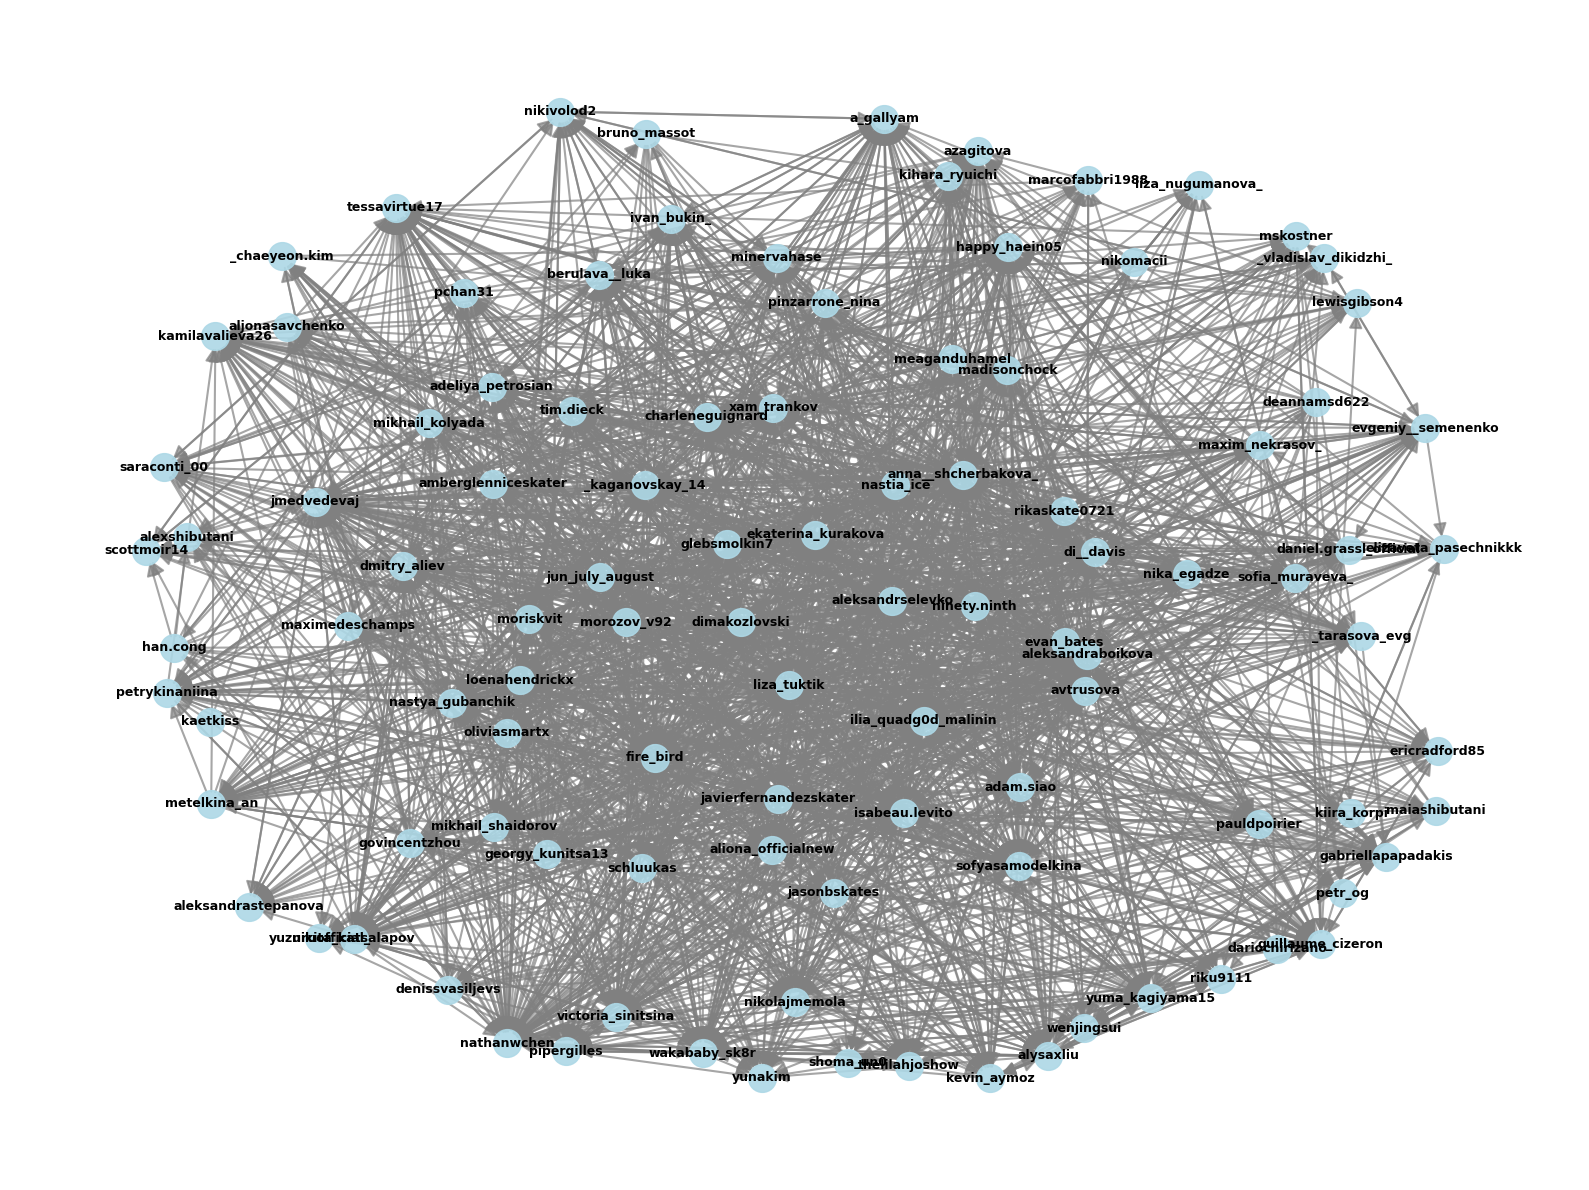

In [7]:
# basic visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

plt.axis('off')

plt.tight_layout()
plt.show()

## Degree distribution: checking whether the network is scale-free

To determine whether a network exhibits scale-free properties, we need to examine whether its degree distribution follows a power law. Since I was working with a directed graph, I was to analyze the distribution of total degrees for each node, calculated by summing the in-degree and out-degree values for every node.

The Kolmogorov-Smirnov test was used to assess the goodness-of-fit between the empirical degree distribution and a theoretical power-law model. To perform this analysis, a `Fit` object from the `powerlaw` library was created. It automatically fits a power-law distribution to the data by finding the optimal lower bound (`xmin`) where the power-law behavior begins. The fit's quality (goodness of fit) is quantified by the Kolmogorov-Smirnov statistic (D) (`.KS()` method). This statistic measures the maximum distance between the  CDF of the empirical data and the CDF of the fitted theoretical power-law model. A smaller D value indicates a better fit.

In [8]:
degrees = [G.in_degree()[node] + G.out_degree()[node] for node in G.nodes]

In [9]:
fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
print(f"Optimal lower bound: {fit.xmin}")
print(f"Power law exponent (alpha): {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test: {fit.power_law.KS():.3f}")

Optimal lower bound: 49.0
Power law exponent (alpha): 4.710
D-value of Kolmogorov-Smirnov test: 0.115


The analysis of the empirical degree distribution using the Kolmogorov-Smirnov goodness-of-fit test indicates that the observed network does not exhibit scale-free properties: the usual threshold for satiafactory fitting is <.05, and we have 0.115. 

I compared the empirical distribution against a theoretical null model using a random network of comparable size and density. For this purpose, the Barabási–Albert random graph model will be implemented to generate a graph with an equal number of nodes and an approximate matching of the average degree. This model was chosen because it provides an opportunity to generate scale-free random network.

In [10]:
G_undirected = G.to_undirected()
n = G_undirected.number_of_nodes()
m = int(G_undirected.number_of_edges() / n)
random_BA = nx.barabasi_albert_graph(n, m)
random_degrees = [i for i in dict(random_BA.degree).values()]

fit = powerlaw.Fit(random_degrees, discrete=True, verbose=False)
print(f"Optimal lower bound for random graph: {fit.xmin}")
print(f"Power law exponent (alpha) for random graph:: {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test for random graph:: {fit.power_law.KS():.3f}")

Optimal lower bound for random graph: 16.0
Power law exponent (alpha) for random graph:: 3.044
D-value of Kolmogorov-Smirnov test for random graph:: 0.073


As evident from the analysis, the random Barabási-Albert network exhibits a degree distribution that follows the power-law, whereas the created network does not demonstrate an appropriate fit to this model, as indicated by the Kolmogorov-Smirnov test values.

Additionally, I conducted a pairwise statistical KS-test to calculate the p-value and determine whether the degree distributions of our empirical network and the random Barabási-Albert model differ significantly.

In [11]:
_, p_value = stats.ks_2samp(degrees, random_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


The extremely small p-value indicates a statistically significant difference between the degree distributions. Therefore, we reject the null hypothesis that the two distributions are identical. This finding suggests that the observed network **is not scale-free**.

## Average distance 

Unfortunately, the graph lacks strong connectivity. Consequently, when running the following code:
```
print('Radius: ', nx.radius(G))
print('Diameter: ', nx.diameter(G))
print('Average shortest path length: ', nx.average_shortest_path_length(G))
```
I get the following error:
`NetworkXError: Found infinite path length because the digraph is not strongly connected.`
Some nodes are unreachable, therefore, I focused on the analysis of largest strongly connected component of the graph.

In [12]:
# getting the list of strongly connected components
strongly_connected = nx.strongly_connected_components(G)

# finding the largest component
largest_component_nodes = max(list(strongly_connected), key=len)
largest_component = G.subgraph(largest_component_nodes)
print(f"Nodes: {largest_component.number_of_nodes()}, Edges: {largest_component.number_of_edges()}")

Nodes: 98, Edges: 2249


Fortunately, the largest connected component does not appear to differ significantly from the original graph: it contains only 6 fewer nodes and 75 fewer edges. This indicates that we can conduct distance analysis with a high degree of confidence. Clustering coefficient was calculated for the full graph.

In [13]:
print(f'Actual Radius: {nx.radius(largest_component)}')
print(f'Actual Diameter: {nx.diameter(largest_component)}')
print(f'Actual average shortest path length: {nx.average_shortest_path_length(largest_component):.3f}')
print(f'Actual average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.3f}')
print(f"Actual clustering coefficient: {nx.average_clustering(G):.3f}")

Actual Radius: 3
Actual Diameter: 4
Actual average shortest path length: 1.871
Actual average degree: 44.692
Actual clustering coefficient: 0.390


Now let's compare this results to the random network generated by Watts-Strogatz algorithm in order to check whether the created network is a small world. If the metrics do not differ significantly, we can say that our network is a small world by the assumption that random networks represent small world features.

In [14]:
n = G_undirected.number_of_nodes()
avg_degree = sum(dict(G_undirected.degree()).values()) / n
k = int(round(avg_degree))
random_WS = nx.watts_strogatz_graph(n, k, p=0.1, seed=seed)

In [15]:
print(f'Theoretical random network  Radius: {nx.radius(random_WS)}')
print(f'Theoretical random network Diameter: {nx.diameter(random_WS)}')
print(f'Theoretical random network average shortest path length: {nx.average_shortest_path_length(random_WS):.3f}')
print(f'Theoretical random network average degree: {sum(dict(random_WS.degree()).values()) / random_WS.number_of_nodes():.3f}')
print(f"Theoretical random network clustering coefficient: {nx.average_clustering(random_WS):.3f}")

Theoretical random network  Radius: 2
Theoretical random network Diameter: 3
Theoretical random network average shortest path length: 1.684
Theoretical random network average degree: 34.000
Theoretical random network clustering coefficient: 0.582


The comparison reveals close similarity in average path lengths (1.684 vs. 1.871) and significant but not extreme differences in other metrics. To statistically validate whether these differences are meaningful, I performed a Kolmogorov-Smirnov test to check if the degree distributions significantly differ between the networks.

In [16]:
ws_degrees = [i for i in dict(random_WS.degree).values()]
_, p_value = stats.ks_2samp(degrees, ws_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


The statistical test revealed different degree distributions, yet the average path lengths remain nearly identical (1.871 vs 1.684). This suggests that while connection patterns differ from random networks, the network still may achieve efficient global connectivity.

The lower clustering coefficient (0.390 vs 0.582) indicates that skaters' Instagram followings form fewer closed triangles than random connections would. This suggests professional rather than social networking patterns, where following reflects career awareness rather than mutual friendships. Combined with the short average path lengths, this reveals an efficiently connected but locally sparse professional network.

## Gorgeous network layout

Since I have collected information about their ISU scores and discipline, let's visualize it accordingly. The score distribution is as follows:

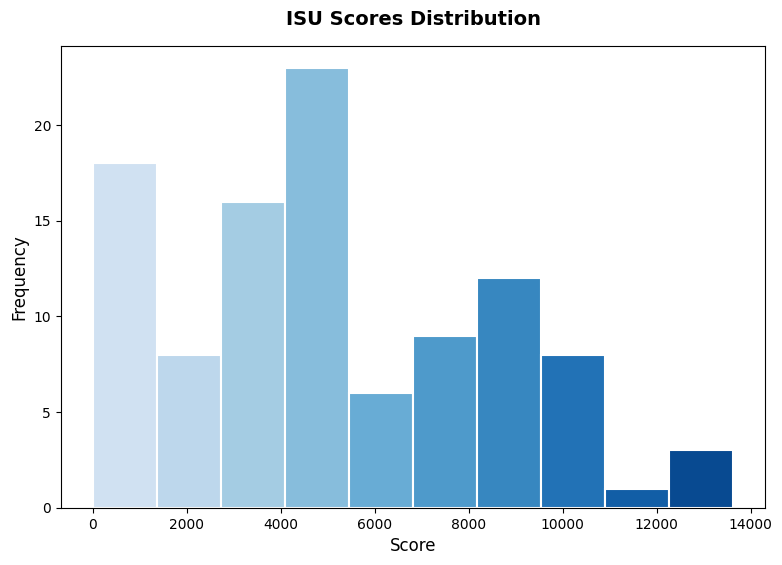

In [17]:
isu_scores = [data['score'] for node, data in G.nodes(data=True)]

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(isu_scores, bins=10, edgecolor='white', 
                            linewidth=1.5)

colors = plt.cm.Blues(np.linspace(0.2, 0.9, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])

plt.title('ISU Scores Distribution', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(False)
plt.savefig('visualisations/scores_distribution.png', dpi=400)

There is a reasonably small but notable number of athletes with scores > 10,000. Let's create a visualization with the following features:
- node color represents discipline;
- node size represents ISU score;
- labels (i.e., skaters' real names, not Instagram nicknames) are displayed only for nodes with scores > 10,000;
- edges connected to these high-scoring nodes are shown with full opacity, while other edges have transparency.

In [18]:
inG = G.to_undirected()

disciplines = [inG.nodes[node]['discipline'] for node in inG.nodes()]
unique_disciplines = list(set(disciplines))
discipline_mapping = {disc: i for i, disc in enumerate(unique_disciplines)}
    
colormap = plt.colormaps.get_cmap('Pastel1')
node_colors = [colormap(discipline_mapping[disc]) for disc in disciplines]
scores = [inG.nodes[node]['score'] for node in inG.nodes()]
    
min_size, max_size = 5, 1000
score_norm = Normalize(vmin=min(scores), vmax=max(scores))
node_sizes = [min_size + (max_size - min_size) * score_norm(score) for score in scores]
    
high_score_nodes = []
high_score_labels = {}
    
for node in inG.nodes():
    score = inG.nodes[node].get('score', 0)
    if score > 10000:
        high_score_nodes.append(node)
        name = inG.nodes[node].get('name', node)
        high_score_labels[node] = name

edge_alpha = list()
edge_width = list()
high_score_edges = []
other_edges = []
    
for edge in inG.edges():
    u, v = edge
    if u in high_score_nodes and v in high_score_nodes:
        edge_alpha.append(0.1)
        edge_width.append(1.5)
        inG[u][v]['kawaii_weight'] = 20.
    else:
        edge_alpha.append(0.1)
        edge_width.append(0.1)
        if u in high_score_nodes or v in high_score_nodes:
            inG[u][v]['kawaii_weight'] = 2
        else:
            inG[u][v]['kawaii_weight'] = 1

layout = nx.kamada_kawai_layout(inG, weight='kawaii_weight')

all_params = {'nodes_params': {'G': inG,
                               'pos': layout,
                               'node_size': node_sizes,
                               'node_color': node_colors,
                               'alpha':0.5},
              'edges_params': {'G': inG,
                               'pos': layout,
                               'alpha': edge_alpha,
                              'width': edge_width},
              'labels_params': {
                  'G': inG,
                  'pos': layout,
                  'labels': high_score_labels
              }
             }

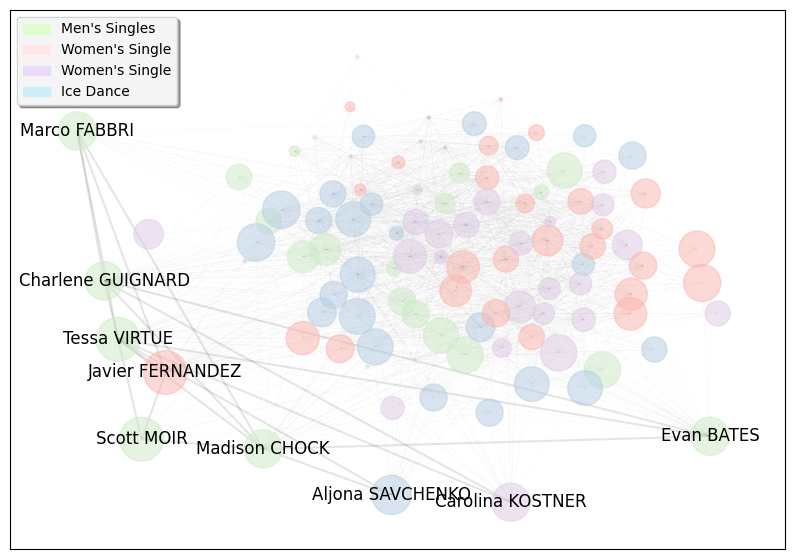

In [19]:
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])

legend_patches = [
    mpatches.Patch(color='#defcce', label="Men's Singles"),
    mpatches.Patch(color='#ffe6e6', label="Women's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Ice Dance")
]

plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/basic_graph.png", dpi=400)
plt.show()

# Structural Analysis

## Differences and similarity with ER/BA/WS models and the reasons for it

Finally, I generated a random graph following a Poisson degree distribution (Erdős–Rényi model) to test whether my network's structure is random. 

In [19]:
m = G.number_of_edges()
n = G.number_of_nodes()
p = m/(n*(n-1)) 
random_ER = nx.erdos_renyi_graph(n, p, directed=True, seed=seed)

er_degrees = [random_ER.in_degree()[node] + random_ER.out_degree()[node] for node in random_ER.nodes]

_, p_value = stats.ks_2samp(degrees, er_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


Performing a Kolmogorov-Smirnov test on the degree distributions yielded a very small p-value, indicating that my network's structure is statistically different from random and therefore unlikely to be explained by chance connections.

Here's a short summarization of what I've learned from comparing my network to ER/BA/WS models
| Model | Property to be extracted | p-value of KS-test | Other values (observed vs random) | Interpretation |
|-------|--------------------------|---------------------|--------------|----------------|
| **Erdős–Rényi model** | randomness of the network | ≈ 0 |  | degree distribution significantly different from random |
| **Barabási–Albert model** | scale-free feature presence | ≈ 0 | *Optimal lower bound:* 49 vs 27 <br> *Alpha*: 4.710 vs 3.871 <br> *D-value of KS*: 0.115 vs 0.072 | the resulting network is not scale-free; the reason for that might lie in several reasons: <br> - relatively small size of the network; <br> - possible imbalance in the selected skater sample (I have not managed to check whether they are balanced in terms of coaching schools and countries); <br> - stratification by country/coach; unfortunately, I have not collected these data, and we cannot check it during the community detection part |
| **Watts-Strogatz** | small-world presence | ≈ 0 | *Radius*: 3 vs 2 <br> *Diametr*: 4 vs 3 <br> *Average shortest path length*: 1.871 vs 1.684 <br> *Average Degree*: 44.692 vs 34 <br> *Clustering coefficient*: 0.39 vs  0.582 | the resulting network may have small world property |

## Centrality measures

I calculated various centrality measures to determine whether any correlation exists between centrality measures and point distributions. The following measures were calculated:
- degree centrality;
- closeness centrality;
- betweenness centrality;
- eigenvector centrality.

### ISU-score correspondance to structural properties

In [20]:
def calculate_correlation_coeff(G, centrality_measure):
    centrality_functions = {'in_degree_centrality': nx.in_degree_centrality,
                            'out_degree_centrality': nx.out_degree_centrality,
                           'closeness_centrality': nx.closeness_centrality,
                           'betweenness_centrality': nx.betweenness_centrality,
                           'eigenvector_centrality': nx.eigenvector_centrality,
                           'pagerank': nx.pagerank}

    c_f = centrality_functions[centrality_measure]
    measures = c_f(G)
    centrality_values = list()
    isu_scores = list()
    for node, data in G.nodes(data=True):
        centrality_values.append(measures[node])
        isu_scores.append(data['score'])

    pearson, p_value = stats.pearsonr(centrality_values, isu_scores)
    return (measures, pearson, p_value)

In [21]:
# I could not calculate the degree centrality as my graph had multigraphs, that's why
# I calculated these values separately
in_degree_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'in_degree_centrality')
print("Results for in_degree_centrality calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

out_degree_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'out_degree_centrality')
print("Results for out_degree_centrality calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

closeness_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'closeness_centrality')
print("Results for closeness_centrality calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

betweenness_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'betweenness_centrality')
print("Results for betweenness_centrality calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

eigenvector_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'eigenvector_centrality')
print("Results for eigenvector_centrality calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

Results for in_degree_centrality calculations
Pearson correlation: -0.044, P-value: 0.654
Results for out_degree_centrality calculations
Pearson correlation: -0.163, P-value: 0.099
Results for closeness_centrality calculations
Pearson correlation: -0.022, P-value: 0.826
Results for betweenness_centrality calculations
Pearson correlation: -0.104, P-value: 0.294
Results for eigenvector_centrality calculations
Pearson correlation: -0.107, P-value: 0.281


The analysis reveals no significant relationships between ISU points scores and network centrality measures. All correlations are weak and statistically insignificant (p > 0.05), suggesting that an athlete's network position does not meaningfully predict their competition scores. Network centrality appears unrelated to ISU performance in this dataset.

Now let's do some manual work and extract the top-skaters based on these four centraluty degrees values.

In [22]:
def get_top_n_by_centrality(centrality_measures, n=5, centrality_name='in-degree centrality', print_things=True, descending=True):

    sorted_nodes = sorted(centrality_measures.items(),
                          key=lambda x: x[1], 
                          reverse=descending)
    
    top_nodes = sorted_nodes[:n]

    if print_things:
        for node, value in top_nodes:
            print(f"{G.nodes(data=True)[node]['name']}'s  {centrality_name} value is {value:.3f}")
    
    return top_nodes

### Top-N: descending order

In [23]:
top_skaters_by_indegree = get_top_n_by_centrality(in_degree_centrality_values)

Elizaveta TUKTAMYSHEVA's  in-degree centrality value is 0.670
Nathan CHEN's  in-degree centrality value is 0.670
Ilia MALININ's  in-degree centrality value is 0.641
Evgenia MEDVEDEVA's  in-degree centrality value is 0.641
Anna SHCHERBAKOVA's  in-degree centrality value is 0.563


In [24]:
top_skaters_by_outdegree = get_top_n_by_centrality(out_degree_centrality_values, centrality_name='out-degree centrality')

Anna SHCHERBAKOVA's  out-degree centrality value is 0.485
Isabeau LEVITO's  out-degree centrality value is 0.456
Elizaveta TUKTAMYSHEVA's  out-degree centrality value is 0.417
Alexandra TRUSOVA's  out-degree centrality value is 0.417
Diana DAVIS's  out-degree centrality value is 0.417


In [25]:
top_skaters_by_closeness = get_top_n_by_centrality(closeness_centrality_values, centrality_name='closeness centrality')

Elizaveta TUKTAMYSHEVA's  closeness centrality value is 0.734
Nathan CHEN's  closeness centrality value is 0.728
Ilia MALININ's  closeness centrality value is 0.717
Evgenia MEDVEDEVA's  closeness centrality value is 0.717
Anna SHCHERBAKOVA's  closeness centrality value is 0.676


In [26]:
top_skaters_by_betweenness = get_top_n_by_centrality(betweenness_centrality_values, centrality_name='betweenness centrality')

Elizaveta TUKTAMYSHEVA's  betweenness centrality value is 0.055
Isabeau LEVITO's  betweenness centrality value is 0.051
Anna SHCHERBAKOVA's  betweenness centrality value is 0.042
Ilia MALININ's  betweenness centrality value is 0.032
Evgenia MEDVEDEVA's  betweenness centrality value is 0.028


In [27]:
top_skaters_by_eigenvectors = get_top_n_by_centrality(eigenvector_centrality_values, centrality_name='eigenvectors centrality')

Elizaveta TUKTAMYSHEVA's  eigenvectors centrality value is 0.237
Nathan CHEN's  eigenvectors centrality value is 0.235
Evgenia MEDVEDEVA's  eigenvectors centrality value is 0.230
Anna SHCHERBAKOVA's  eigenvectors centrality value is 0.225
Ilia MALININ's  eigenvectors centrality value is 0.215


### Top-N: ascending order

In [28]:
antitop_skaters_by_indegree = get_top_n_by_centrality(in_degree_centrality_values, descending=False)

Kaetlyn OSMOND's  in-degree centrality value is 0.000
Deanna STELLATO-DUDEK's  in-degree centrality value is 0.010
Cong HAN's  in-degree centrality value is 0.019
Niccolo MACII's  in-degree centrality value is 0.019
Bruno MASSOT's  in-degree centrality value is 0.029


In [29]:
antitop_skaters_by_outdegree = get_top_n_by_centrality(out_degree_centrality_values, centrality_name='out-degree centrality', descending=False)

Yuzuru HANYU's  out-degree centrality value is 0.000
Petr GUMENNIK's  out-degree centrality value is 0.000
Yuna KIM's  out-degree centrality value is 0.000
Shoma UNO's  out-degree centrality value is 0.000
Kiira KORPI's  out-degree centrality value is 0.000


In [30]:
antitop_skaters_by_closeness = get_top_n_by_centrality(closeness_centrality_values, centrality_name='closeness centrality', descending=False)

Kaetlyn OSMOND's  closeness centrality value is 0.000
Cong HAN's  closeness centrality value is 0.331
Deanna STELLATO-DUDEK's  closeness centrality value is 0.366
Bruno MASSOT's  closeness centrality value is 0.373
Dario CIRISANO's  closeness centrality value is 0.382


In [31]:
antitop_skaters_by_betweenness = get_top_n_by_centrality(betweenness_centrality_values, centrality_name='betweenness centrality', descending=False)

Yuzuru HANYU's  betweenness centrality value is 0.000
Petr GUMENNIK's  betweenness centrality value is 0.000
Yuna KIM's  betweenness centrality value is 0.000
Kaetlyn OSMOND's  betweenness centrality value is 0.000
Shoma UNO's  betweenness centrality value is 0.000


In [32]:
antitop_skaters_by_eigenvectors = get_top_n_by_centrality(eigenvector_centrality_values, centrality_name='eigenvectors centrality', descending=False)

Kaetlyn OSMOND's  eigenvectors centrality value is 0.000
Cong HAN's  eigenvectors centrality value is 0.002
Deanna STELLATO-DUDEK's  eigenvectors centrality value is 0.005
Bruno MASSOT's  eigenvectors centrality value is 0.007
Niccolo MACII's  eigenvectors centrality value is 0.008


### Analysis

First of all, all top-centrality skaters competed and achieved significant results during the last three Olympic cycles (2015–2025). The oldest is Elizaveta Tuktamysheva, born in 1996; the youngest is Isabeau Levito, born in 2007. On the other hand, the majority of antitop skaters have already ended their careers. This suggests that athlete **age may be an important factor** influencing their centrality measures, which makes sense since younger people are more prone to Instagram usage.

Furthermore, all top-centrality skaters have participated in the World Championships; all but Diana Davis have won at least one medal, and most have Olympic experience (exceptions: Elizaveta Tuktamysheva; Ilya Malinin and Isabeau Levito have already qualified for the 2026 Olympic Games in Milano). This explains why they are hubs in many ways. However, some antitop skaters have impressive achievements too: Yuzuru Hanyu and Yuna Kim are among the most privileged athletes of all time. Interestingly, they rank low in betweenness centrality because they have very few (Kim) or no (Hanyu) subscriptions to other skaters. Paradoxically, this can be explained by their extreme popularity: they use their Instagram accounts not for direct communication with other skaters but for advertising, as they are highly sought after in that sphere (e.g., Yuna Kim is the face of Nike and Samsung).

It can be noticed that Elizaveta Tuktamysheva ranks top-1 in all centrality measures except out-degree centrality, where Anna Shcherbakova is number one. This can be explained by multiple factors:
- Elizaveta Tuktamysheva began her senior career in 2012 and has competed (and therefore become acquainted) with many older skaters whom younger athletes like Shcherbakova, Trusova, or Levito have not encountered;
- unlike Evgenia Medvedeva, who ended her career in 2019, Elizaveta Tuktamysheva continued competing until autumn 2023 (and officially retired only in December 2025). Thus, she became acquainted with the younger generation and competed against them. Both this factor and the previous one make it clear that Elizaveta Tuktamysheva is a major hub. This is also indirectly proven by the fact that she has the longest career among all athletes except Alyona Savchenko.

Let's vizualize the top-skaters and their edges based on different centrality measures.

In [33]:
def get_viz_params(G, centrality_measure_for_all_skaters):
    inG = G.to_undirected()
    cent_dict = dict(centrality_measure_for_all_skaters)

    disciplines = [inG.nodes[node]['discipline'] for node in inG.nodes()]
    unique_disciplines = list(set(disciplines))
    discipline_mapping = {disc: i for i, disc in enumerate(unique_disciplines)}
        
    colormap = plt.colormaps.get_cmap('Pastel1')
    node_colors = [colormap(discipline_mapping[disc]) for disc in disciplines]
    scores = [inG.nodes[node]['score'] for node in inG.nodes()]
        
    min_size, max_size = 5, 1000
    score_norm = Normalize(vmin=min(scores), vmax=max(scores))
    node_sizes = [min_size + (max_size - min_size) * score_norm(score) for score in scores]
        
    highlighted_nodes = []
    highlighted_labels = {}
        
    for node in inG.nodes():
        if node in cent_dict:
            highlighted_nodes.append(node)
            name = inG.nodes[node].get('name', node)
            highlighted_labels[node] = name
    
    edge_alpha = list()
    edge_width = list()
    edge_color = list()
        
    for edge in inG.edges():
        u, v = edge
        if u in highlighted_nodes and v in highlighted_nodes:
            edge_alpha.append(0.5)
            edge_width.append(1.5)
            edge_color.append("#ffdee8")
            inG[u][v]['kawaii_weight'] = 20.
        elif u in highlighted_nodes or v in highlighted_nodes:
            edge_alpha.append(0.5)
            edge_width.append(1.5)
            edge_color.append("#ffdee8")
            inG[u][v]['kawaii_weight'] = 2.
        else:
            edge_alpha.append(0.5)
            edge_width.append(0.5)
            edge_color.append("#caf1ff")
            inG[u][v]['kawaii_weight'] = 1
    
    layout = nx.kamada_kawai_layout(inG, weight='kawaii_weight')
    
    all_params = {'nodes_params': {'G': inG,
                                   'pos': layout,
                                   'node_size': node_sizes,
                                   'node_color': node_colors,
                                   'alpha':0.5},
                  'edges_params': {'G': inG,
                                   'pos': layout,
                                   'alpha': edge_alpha,
                                  'width': edge_width,
                                  'edge_color': edge_color},
                  'labels_params': {
                      'G': inG,
                      'pos': layout,
                      'labels': highlighted_labels
                  }
                 }
    return all_params

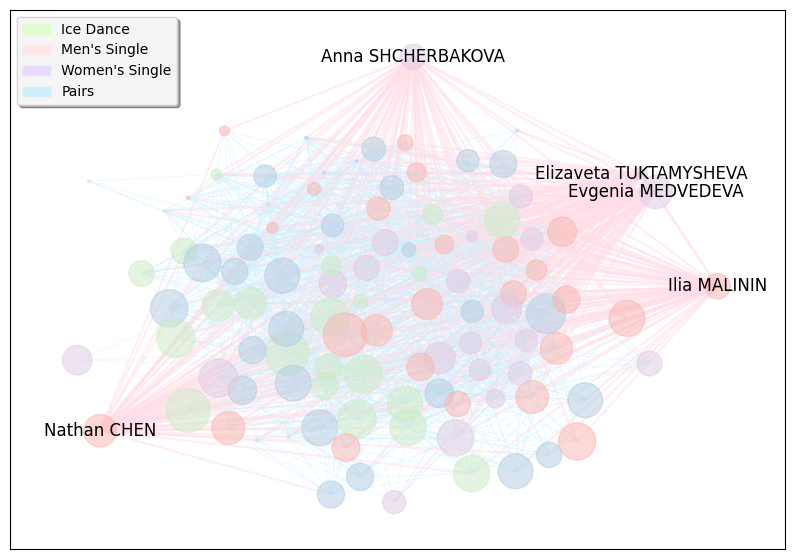

In [37]:
cl = get_top_n_by_centrality(in_degree_centrality_values, n=5, centrality_name='in-degree centrality', print_things=False)
all_params = get_viz_params(G, cl)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])

legend_patches = [
    mpatches.Patch(color='#defcce', label="Ice Dance"),
    mpatches.Patch(color='#ffe6e6', label="Men's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Pairs")
]

plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/in_degree_graph.png", dpi=400)
plt.show()

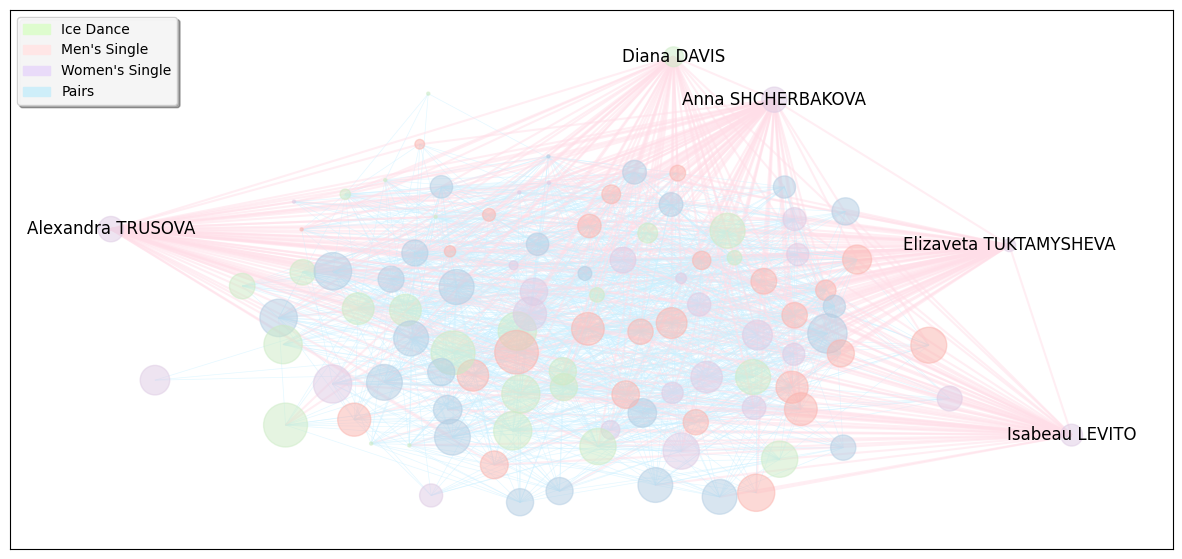

In [36]:
cl = get_top_n_by_centrality(out_degree_centrality_values, n=5, centrality_name='out-degree centrality', print_things=False)
all_params = get_viz_params(G, cl)
plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])


legend_patches = [
    mpatches.Patch(color='#defcce', label="Ice Dance"),
    mpatches.Patch(color='#ffe6e6', label="Men's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Pairs")
]

plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/out_degree_graph.png", dpi=400)
plt.show()

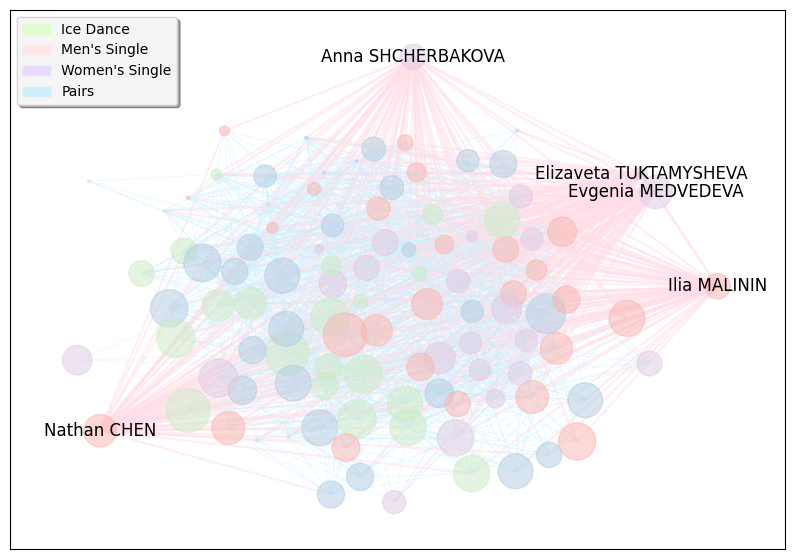

In [38]:
cl = get_top_n_by_centrality(closeness_centrality_values, n=5, centrality_name='closeness centrality', print_things=False)
all_params = get_viz_params(G, cl)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])

legend_patches = [
    mpatches.Patch(color='#defcce', label="Ice Dance"),
    mpatches.Patch(color='#ffe6e6', label="Men's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Pairs")
]

plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/closeness_graph.png", dpi=400)
plt.show()

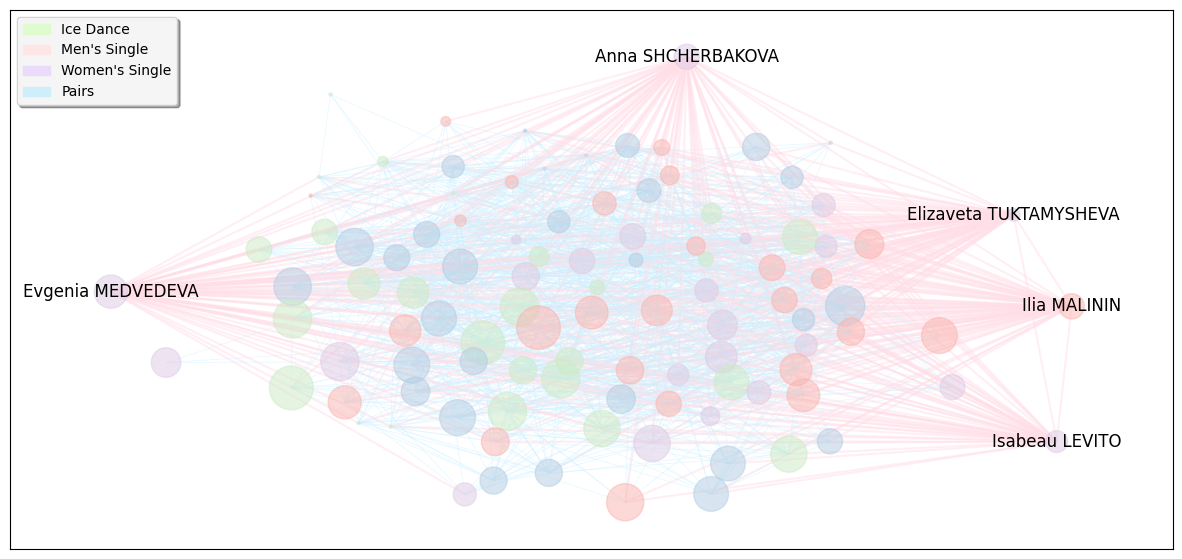

In [39]:
cl = get_top_n_by_centrality(betweenness_centrality_values, n=5, centrality_name='betweenness centrality', print_things=False)
all_params = get_viz_params(G, cl)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])

legend_patches = [
    mpatches.Patch(color='#defcce', label="Ice Dance"),
    mpatches.Patch(color='#ffe6e6', label="Men's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Pairs")
]

plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/betwenness_graph.png", dpi=400)
plt.show()

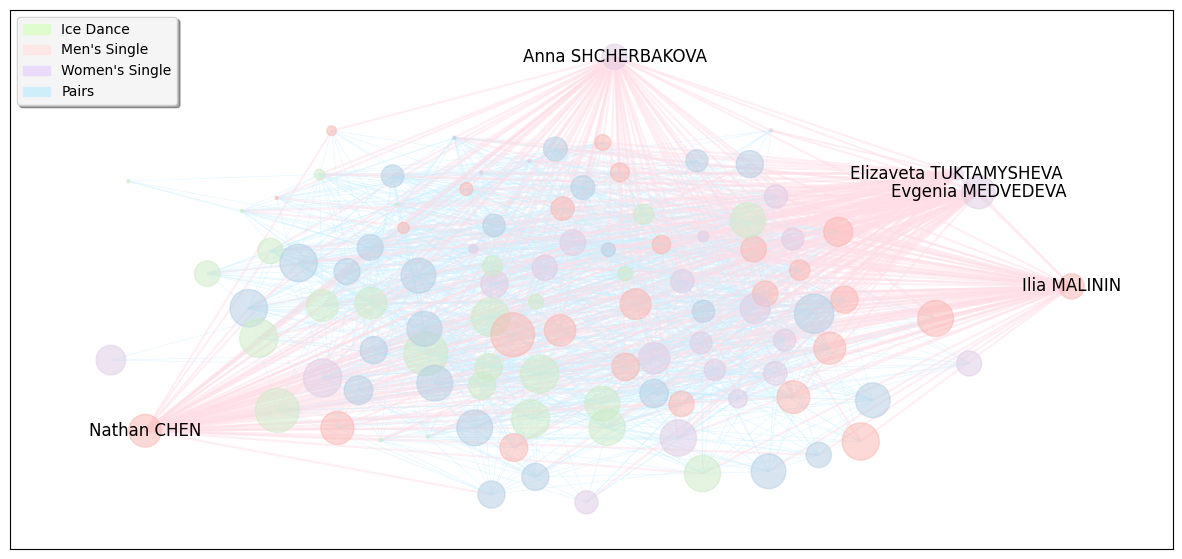

In [40]:
cl = get_top_n_by_centrality(eigenvector_centrality_values, n=5, centrality_name='eigenvector centrality', print_things=False)
all_params = get_viz_params(G, cl)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(**all_params['nodes_params'])
nx.draw_networkx_edges(**all_params['edges_params'])
nx.draw_networkx_labels(**all_params['labels_params'])

legend_patches = [
    mpatches.Patch(color='#defcce', label="Ice Dance"),
    mpatches.Patch(color='#ffe6e6', label="Men's Single"),
    mpatches.Patch(color='#e9dbf9', label="Women's Single"),
    mpatches.Patch(color='#ceeef9', label="Pairs")
]
plt.legend(handles=legend_patches, loc='upper left', frameon=True, 
           fancybox=True, framealpha=0.9, shadow=True)
plt.savefig("visualisations/eigenvector_graph.png", dpi=400)
plt.show()

## PageRank
As we have a directed graph, it would be interesting to analyze PageRank values for each node. In our skater network, this translates to identifying skaters who are "central" not just by being followed, but by being followed by other influential skaters.

In [41]:
pagerank_scores = nx.pagerank(G)

top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
for node, score in top_nodes[:10]:
    print(f"{G.nodes()[node]['name']}: {score:.3f}")

Evgenia MEDVEDEVA: 0.028
Mark KONDRATIUK: 0.028
Elizaveta TUKTAMYSHEVA: 0.026
Nathan CHEN: 0.026
Anna SHCHERBAKOVA: 0.025
Ilia MALININ: 0.024
Alexandra TRUSOVA: 0.020
Tessa VIRTUE: 0.018
Maxim TRANKOV: 0.017
Victoria SINITSINA: 0.017


In [42]:
# let's also analyze whether there is some correlation between ISU rating scores and pagerank scores
in_degree_centrality_values, pearson_corr, p_value = calculate_correlation_coeff(G, 'pagerank')
print("Results for PageRank calculations")
print(f"Pearson correlation: {pearson_corr:.3f}, P-value: {p_value:.3f}")
print("="*43)

Results for PageRank calculations
Pearson correlation: -0.061, P-value: 0.538


The emergence of Evgenia Medvedeva and Mark Kondratiuk in the top tier of the PageRank rankings, despite them not being the most-mentioned skaters by raw in-degree (Mark wasn't mentioned at all), highlights the algorithm's ability to identify influence through network structure rather than just popularity.

Medvedeva's high score can be attributed to her position as a hub receiving attention from other influential nodes. Her acclaimed international show career and her training under the legendary coach Brian Orser likely connect her to a network of elite skaters, coaches, and commentators. Follows from these highly connected individuals carry more weight in the PageRank calculation, amplifying her standing.

Similarly, Mark Kondratiuk's presence is driven by his role in high-profile team events, such as the Olympic team competition. This positioned him directly alongside and likely within the mention networks of top skaters like Kamila Valieva and Victoria Sinitsina. Being referenced by these central figures provides a significant boost in PageRank, as their endorsements are algorithmically valuable.

# Community detection

I selected Louvain for its efficiency with dense social graphs and its modularity optimization suited to overlapping social circles. Girvan-Newman provides a hierarchical alternative. Both algorithms address directed edges and homogeneous node composition while revealing different structural perspectives.

## Louvain algorithm

In [43]:
lov_communities = nx_comm.louvain_communities(G, weight=None, seed=seed)
print(f"{nx_comm.modularity(G, lov_communities):.3f}")

0.185


## Girvan-Newman algorithm

In [44]:
gn_communities = nx.community.girvan_newman(G)
for i in range(4):
    partition = next(gn_communities)
print(f"{nx_comm.modularity(G, partition):.3f}")

-0.000


### Analysis

The Louvain algorithm's modularity score of 0.185 indicates weak community structure in this skater network. Girvan-Newman's near-zero score reflects its different approach, as it removes high-betweenness edges, which often fails to capture cohesive communities.